In [2]:
# Import libraries
import os
import zipfile
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision.models import vgg19
import torch.nn.functional as F
from torch import optim

In [3]:
# Set device
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Constants
BATCH_SIZE = 16
LR = 3e-4
EPOCHS = 20
IMG_CHANNELS = 3
low_res_size = 128
high_res_size = 256

In [5]:
# Defining image transformation
transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor()
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor()
])

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, csv_file):
        super(ImageDataset, self).__init__()
        self.root_dir = root_dir
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        low_res_name = self.data.iloc[index]['low_res']
        high_res_name = self.data.iloc[index]['high_res']
        
        low_res_path = os.path.join(self.root_dir, 'low res', low_res_name)
        high_res_path = os.path.join(self.root_dir, 'high res', high_res_name)
        
        low_res = np.array(Image.open(low_res_path))[:, :, :3]
        high_res = np.array(Image.open(high_res_path))[:, :, :3]
        
        low_res = transform_low(low_res)
        high_res = transform_high(high_res)
        
        return low_res, high_res

In [7]:
dataset_path = "/Users/arman/Desktop/Atml_mini_project/myenv/data/Image Super Resolution - Unsplash"
csv_file_path = os.path.join(dataset_path, '/Users/arman/Desktop/Atml_mini_project/myenv/data/Image Super Resolution - Unsplash/image_data.csv')
train_dataset = ImageDataset(root_dir=dataset_path, csv_file=csv_file_path)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
# Defining the Perceptual Loss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = vgg19(pretrained=True).features[:35].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.to(device)

    def forward(self, generated, target):
        gen_features = self.vgg(generated)
        target_features = self.vgg(target)
        return F.mse_loss(gen_features, target_features)


In [16]:
# Defining the GAN Model Components
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return out + identity  # Adding skip connection
    
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()
        self.initial = nn.Conv2d(in_channels, num_channels, kernel_size=7, stride=1, padding=3)
        self.res_blocks = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=7, stride=1, padding=3)
    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = self.upsample(x)
        x = self.final(x)
        return torch.sigmoid(x)

class Critic(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super(Critic, self).__init__()
        layers = []
        for feature in features:
            layers.append(nn.Conv2d(in_channels, feature, kernel_size=4, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(feature))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            in_channels = feature
        self.blocks = nn.Sequential(*layers)
        self.fc = nn.Linear(512 * 16 * 16, 1)  # Change as per image size

    def forward(self, x):
        x = self.blocks(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [17]:
def gradient_penalty(critic, real, fake, device="mps"):
    batch_size, c, h, w = real.shape
    # Interpolate between real and fake images
    alpha = torch.rand(batch_size, 1, 1, 1).repeat(1, c, h, w).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Compute gradients with respect to inputs
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.size(0), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

In [18]:
def train_wgan_gp(loader, critic, generator, opt_critic, opt_generator, perceptual_loss, lambda_gp=10, critic_steps=5):
    for low_res, high_res in loader:
        low_res, high_res = low_res.to(device), high_res.to(device)

        # Train Critic multiple times before updating Generator
        for _ in range(critic_steps):
            # Generate fake high-resolution images
            fake_hr = generator(low_res)

            # Critic scores for real and fake images
            critic_real = critic(high_res).reshape(-1)
            critic_fake = critic(fake_hr.detach()).reshape(-1)

            # Wasserstein loss
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))

            # Gradient penalty
            gp = gradient_penalty(critic, high_res, fake_hr, device)
            loss_critic += lambda_gp * gp

            # Optimize Critic
            opt_critic.zero_grad()
            loss_critic.backward()
            opt_critic.step()

        # Train Generator
        fake_hr = generator(low_res)
        critic_fake = critic(fake_hr).reshape(-1)
        adversarial_loss = -torch.mean(critic_fake)  # WGAN loss for generator

        # Perceptual and pixel-wise loss
        perceptual = perceptual_loss(fake_hr, high_res)
        pixel_loss = nn.functional.mse_loss(fake_hr, high_res)

        # Total generator loss
        g_loss = adversarial_loss + 0.006 * perceptual + 0.1 * pixel_loss

        # Optimize Generator
        opt_generator.zero_grad()
        g_loss.backward()
        opt_generator.step()

    return g_loss.item(), loss_critic.item()

In [ ]:
# Initialize models and optimizers
gen = Generator().to(device)
critic = Critic().to(device)
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_critic = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.5, 0.999))
perceptual_loss = PerceptualLoss()

# Training loop
d_losses = []
g_losses = []
for epoch in range(EPOCHS):
    gen_loss, critic_loss = train_wgan_gp(
        loader=train_loader, 
        critic=critic, 
        generator=gen, 
        opt_critic=opt_critic, 
        opt_generator=opt_gen, 
        perceptual_loss=perceptual_loss
    )

    d_losses.append(critic_loss)
    g_losses.append(gen_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Critic Loss: {critic_loss:.4f}, Generator Loss: {gen_loss:.4f}")
    plot_examples(generator=gen, dataset=train_dataset, num_images=3)

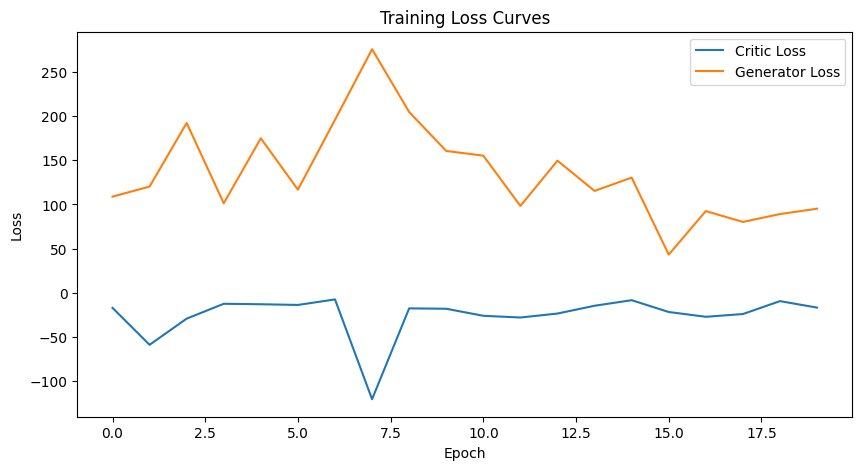

In [20]:
import matplotlib.pyplot as plt

def plot_loss_curves(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label="Critic Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curves")
    plt.legend()
    plt.show()

# Assuming d_losses and g_losses were recorded during training
plot_loss_curves(d_losses, g_losses)

In [23]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torch

def evaluate_model(generator, dataset, num_images=100):
    generator.eval()
    psnr_values = []
    ssim_values = []

    data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    with torch.no_grad():
        for i, (low_res, high_res) in enumerate(data_loader):
            if i >= num_images:
                break
            
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            
            # Generate high-resolution image
            generated_hr = generator(low_res)
            
            # Move to CPU for evaluation
            generated_hr = generated_hr.squeeze().cpu().numpy().transpose(1, 2, 0)
            high_res = high_res.squeeze().cpu().numpy().transpose(1, 2, 0)
            
            # Calculate PSNR
            psnr_value = psnr(high_res, generated_hr, data_range=generated_hr.max() - generated_hr.min())
            psnr_values.append(psnr_value)

            # Calculate SSIM with adjusted parameters
            ssim_value = ssim(
                high_res,
                generated_hr,
                multichannel=True,         # Specify that the image is RGB
                win_size=3,                # Set win_size to a smaller odd number
                channel_axis=2,            # Set channel_axis for multichannel images
                data_range=1.0             # Assuming images are normalized to [0, 1]
            )
            ssim_values.append(ssim_value)

    avg_psnr = sum(psnr_values) / len(psnr_values)
    avg_ssim = sum(ssim_values) / len(ssim_values)
    
    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    
    generator.train()
    return avg_psnr, avg_ssim

# Evaluate the generator on the dataset
evaluate_model(generator=gen, dataset=train_dataset, num_images=100)

Average PSNR: 21.1352
Average SSIM: 0.7443


(21.135158963192058, 0.7443359172344208)

# Conclusion and inference
- The PSNR score indicates that the images generated are of moderate quality, i.e they are somewhat close to the ground truth.
- The SSIM value denotes moderate structural similarity which indicates that the model captures structural features but loses finer details or introduces artifacts.

# Sample tests to see results

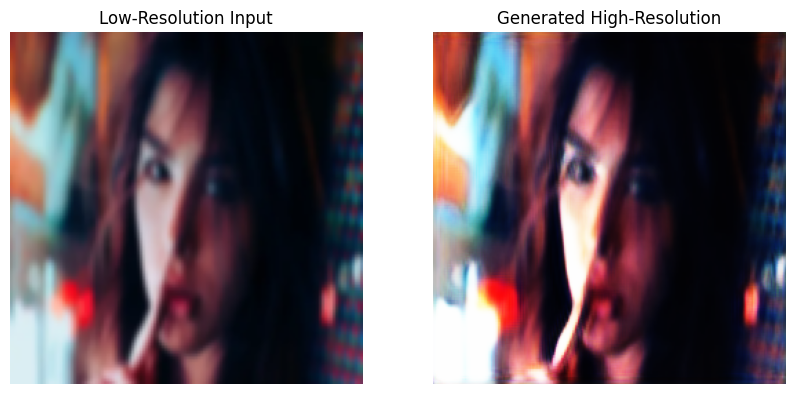

In [24]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

# Load and preprocess the low-resolution input image
def load_low_res_image(image_path, low_res_size=128):
    image = Image.open(image_path).convert("RGB")

    # Define the same transformations you used during training
    transform = transforms.Compose([
        transforms.Resize((low_res_size, low_res_size)),
        transforms.ToTensor()
    ])

    # Transform the image and add a batch dimension
    low_res_image = transform(image).unsqueeze(0)  # Shape: [1, 3, low_res_size, low_res_size]
    return low_res_image

# Function to generate and display the high-resolution output
def generate_high_res_image(generator, low_res_image):
    generator.eval() 

    # Move the image to the device
    low_res_image = low_res_image.to(device)

    # Generate high-resolution image
    with torch.no_grad():
        generated_hr = generator(low_res_image)

    # Move the output back to CPU and remove the batch dimension
    generated_hr = generated_hr.squeeze(0).cpu()

    # Denormalize if necessary (depends on your training setup)
    generated_hr = transforms.ToPILImage()(generated_hr)

    return generated_hr

# Path to low-resolution input image
low_res_image_path = "/Users/arman/Desktop/Atml_mini_project/test.jpeg"

# Load the low-resolution image
low_res_image = load_low_res_image(low_res_image_path, low_res_size=128)

# Generate the high-resolution image
high_res_image = generate_high_res_image(generator=gen, low_res_image=low_res_image)

# Display the results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(transforms.ToPILImage()(low_res_image.squeeze(0)))  # Convert tensor to PIL Image for display
axs[0].set_title("Low-Resolution Input")
axs[0].axis("off")

axs[1].imshow(high_res_image)
axs[1].set_title("Generated High-Resolution")
axs[1].axis("off")

plt.show()

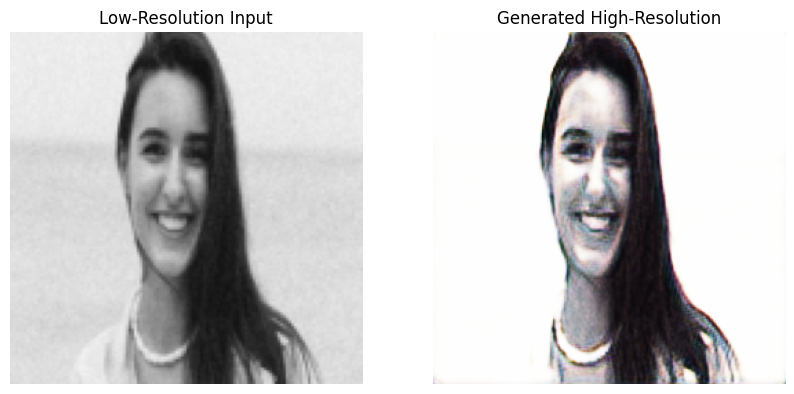

In [25]:
# Path to low-resolution input image
low_res_image_path = "/Users/arman/Desktop/Atml_mini_project/test2.jpeg"

# Load the low-resolution image
low_res_image = load_low_res_image(low_res_image_path, low_res_size=128)

# Generate the high-resolution image
high_res_image = generate_high_res_image(generator=gen, low_res_image=low_res_image)

# Display the results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(transforms.ToPILImage()(low_res_image.squeeze(0)))  # Convert tensor to PIL Image for display
axs[0].set_title("Low-Resolution Input")
axs[0].axis("off")

axs[1].imshow(high_res_image)
axs[1].set_title("Generated High-Resolution")
axs[1].axis("off")

plt.show()

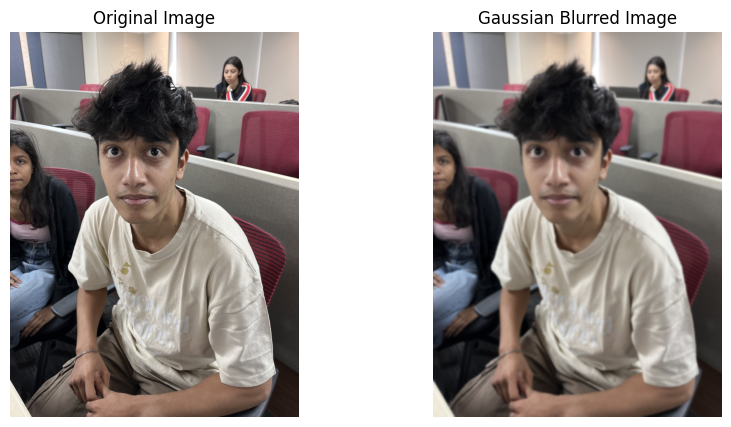

In [30]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = "/Users/arman/Desktop/Atml_mini_project/Image.jpeg" 
image = cv2.imread(image_path)

blurred_image = cv2.GaussianBlur(image, (25, 25), 0)

# Display the original and blurred images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.title("Gaussian Blurred Image")
plt.axis("off")

plt.show()

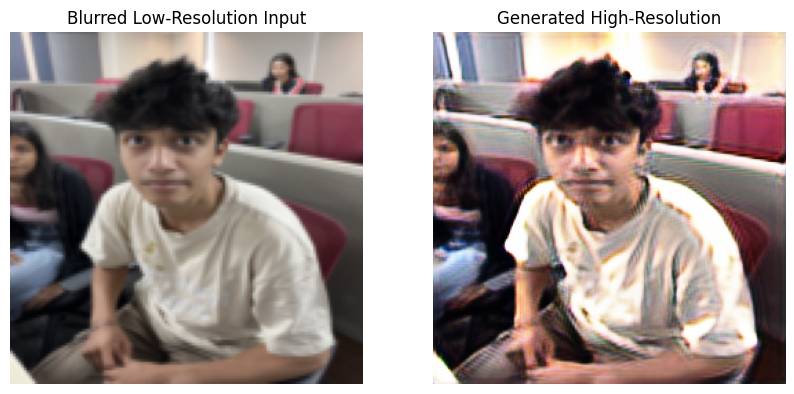

In [32]:
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Load and blur the input image
def load_and_blur_image(image_path, blur_kernel=(25, 25)):
    image = cv2.imread(image_path)  # Load image
    blurred_image = cv2.GaussianBlur(image, blur_kernel, 0)  # Apply Gaussian blur
    return blurred_image

# Load and preprocess the low-resolution blurred image for the GAN model
def load_low_res_image(image, low_res_size=128):
    # Convert from OpenCV BGR to RGB and to PIL format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)
    
    # Define transformations (resize and convert to tensor)
    transform = transforms.Compose([
        transforms.Resize((low_res_size, low_res_size)),
        transforms.ToTensor()
    ])
    
    # Apply transformation and add batch dimension
    low_res_image = transform(image_pil).unsqueeze(0)  # Shape: [1, 3, low_res_size, low_res_size]
    return low_res_image

# Generate high-resolution image from the blurred low-resolution input
def generate_high_res_image(generator, low_res_image):
    generator.eval()  # Set model to evaluation mode
    
    # Move the low-resolution image to the correct device
    low_res_image = low_res_image.to(device)
    
    # Generate high-resolution image
    with torch.no_grad():
        generated_hr = generator(low_res_image)
    
    # Move the output back to CPU and convert to PIL image for display
    generated_hr = transforms.ToPILImage()(generated_hr.squeeze(0).cpu())
    return generated_hr

# Path to your original image
image_path = "/Users/arman/Desktop/Atml_mini_project/Image.jpeg"  

# Step 1: Blur the original image
blurred_image = load_and_blur_image(image_path, blur_kernel=(25, 25))

# Step 2: Load the blurred image as low resolution for the GAN
low_res_image = load_low_res_image(blurred_image, low_res_size=128)

# Step 3: Generate the high-resolution image using the GAN
high_res_image = generate_high_res_image(generator=gen, low_res_image=low_res_image)

# Step 4: Display the results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the blurred (low-resolution) image
axs[0].imshow(transforms.ToPILImage()(low_res_image.squeeze(0)))  # Convert tensor to PIL Image for display
axs[0].set_title("Blurred Low-Resolution Input")
axs[0].axis("off")

# Display the GAN-generated high-resolution image
axs[1].imshow(high_res_image)
axs[1].set_title("Generated High-Resolution")
axs[1].axis("off")

plt.show()